In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pyfftw

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import utils
import plotter

%load_ext autoreload
%autoreload 2

2024-07-09 17:59:58.794392: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-09 17:59:59.040726: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-09 17:59:59.042003: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-09 18:00:02.081594: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-09 18:00:06.686023: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

### Set up bacco: cosmology and power spectrum parameters

In [2]:
idx_LH = 0
idx_LH_str = str(idx_LH)

# order of saved cosmo param files
param_names_all = ['omega_cold', 'sigma_8', 'h', 'omega_baryon', 'n_s', 'seed']
param_names = ['omega_cold', 'sigma_8', 'h']
    
n_grid = 128
n_grid_orig = 512
box_size = 1000.0

In [3]:
# Quijote LH test data

# still had LH0 in map2map emu dir, preeeetty sure its LH0 cosmo params

dir_mocks = f'/dipc/kstoreyf/muchisimocks/data/cosmolib_rerun'
dir_params = f'/dipc/kstoreyf/muchisimocks/data/cosmolib'

fn_sim = f'{dir_mocks}/LH{idx_LH}/pred_disp.npy'
sim_disp = np.load(fn_sim)

fn_dens = f'{dir_mocks}/LH{idx_LH}/lin_field.npy'
dens_lin = np.load(fn_dens)

In [53]:
fn_params = f'{dir_params}/LH{idx_LH}/cosmo_{idx_LH}.txt'
param_vals = np.loadtxt(fn_params)
param_dict = dict(zip(param_names_all, param_vals))
#del param_dict['seed']
print(param_dict)
cosmo = utils.get_cosmo(param_dict)


2024-07-09 18:24:45,639 bacco.cosmo :    initialization took 0.000 secs


{'omega_cold': 0.2775274936564327, 'sigma_8': 0.7049140324569382, 'h': 0.7241123952301097, 'omega_baryon': 0.049, 'n_s': 0.9624, 'seed': 0.0}


In [54]:
cosmo_params_emu = utils.cosmo_bacco_to_cosmo_baccoemu(cosmo)
print(cosmo_params_emu)

{'sigma8_cold': 0.7049140324569382, 'omega_cold': 0.2775274936564327, 'hubble': 0.7241123952301097, 'ns': 0.9624, 'omega_baryon': 0.049, 'expfactor': 1, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0}


In [5]:
k_min = 0.01
k_max = 1.0
n_bins = 30
log_binning = True
n_threads = 4

deposit_method = 'cic'
interlacing = False
correct_grid = True
deconvolve_grid = True
normalise_grid = True

# defaults from bacco.statistics.compute_power
# unless passed or otherwise denoted
args_power = {
    "ngrid": n_grid,
    "box": box_size,
    #"pos": None,
    "vel": None,
    "mass": None,
    "interlacing": interlacing, #default: None
    "unit_in_Mpc": 1,
    "deposit_method": deposit_method, # default: 'cic',
    "bs_method": None,
    "bs_num_triangles": 10000,
    "bs_k1": 0.01,
    "bs_k2": None,
    "bs_deltak": None,
    "log_binning": log_binning,
    "kmin": k_min,
    "kmax": k_max,
    "nbins": n_bins,
    "correct_grid": correct_grid, #default: True,
    "deconvolve_grid": deconvolve_grid, #default: True,
    "normalise_grid": normalise_grid, #default: True,
    "totalmass": None,
    "correct_shotnoise": False,
    "zspace": False,
    "cosmology": cosmo,
    "pmulti_interp": "polyfit",
    "nthreads": n_threads,
    "grid1": None,
    "dilution": None,
    "folds": None,
    "compute_correlation": False, #default: True
    "compute_power2d": False, #default: True
    "jack_error": False,
    "n_jack": None
}

# defaults from bacco.statistics.compute_crossspectrum_twogrids
# unless passed or otherwise denoted
args_power_grid = {
    # "grid1": None,
    # "grid2": None,
    "normalise_grid1": normalise_grid, #default: False
    "normalise_grid2": normalise_grid, #default: False
    "deconvolve_grid1": deconvolve_grid, #default: False
    "deconvolve_grid2": deconvolve_grid, #default: False
    "ngrid": n_grid,
    "box": box_size,
    "mass1": None,
    "mass2": None,
    "interlacing": interlacing, #default: True
    "deposit_method": deposit_method, #default: "tsc",
    "log_binning": log_binning,
    "pk_lt": None,
    "kmin": k_min,
    "kmax": k_max,
    "nbins": n_bins,
    "correct_grid": correct_grid,
    "zspace": False,
    "cosmology": cosmo,
    "pmulti_interp": "polyfit",
    "nthreads": n_threads,
    "compute_correlation": False, #default: True
    "compute_power2d": False, #default: True
    "folds": 1,
    "totalmass1": None,
    "totalmass2": None,
    "jack_error": False,
    "n_jack": None
}

pknbody_dict = {
    'ngrid': n_grid,
    'min_k': k_min,
    'log_binning': log_binning,
    'log_binning_kmax': k_max,
    'log_binning_nbins': n_bins,
    'interlacing': interlacing,
    'depmethod': deposit_method,
    'correct_grid': correct_grid,
    'folds': 1 #default
}
bacco.configuration.update({'number_of_threads': n_threads})
bacco.configuration.update({'pknbody': pknbody_dict})
bacco.configuration.update({'pk' : {'maxk' : k_max}})
bacco.configuration.update({'scaling' : {'disp_ngrid' : n_grid}})


## Make fields

In [6]:

cosmo_params = {
    'neutrino_mass' :  0.0,
    'w0'            : -1.0,
    'wa'            :  0.0,
    'expfactor'     :  1
}

In [7]:
# copied from DataCreationPipeline.py

## Create regular grid and displace particles
print("Generating grid")
grid = bacco.visualization.uniform_grid(npix=n_grid_orig, L=box_size, ndim=3, bounds=False)

print("Adding predicted displacements")
sim_pos = bacco.scaler.add_displacement(None,
                                    sim_disp,
                                    box=box_size,
                                    pos=grid.reshape(-1,3),
                                    vel=None,
                                    vel_factor=0,
                                    verbose=True)[0]

Generating grid


2024-07-09 18:00:24,737 bacco.scaler : Adding displacement field with a vel-factor=0.000000


Adding predicted displacements
bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [8]:
FixedInitialAmplitude = False
seed = int(param_dict['seed'])
sim, disp_field = bacco.utils.create_lpt_simulation(cosmo, box_size, Nmesh=n_grid_orig, Seed=seed,
                                                    FixedInitialAmplitude=FixedInitialAmplitude,InitialPhase=0, 
                                                    expfactor=1, LPT_order=1, order_by_order=None,
                                                    phase_type=1, ngenic_phases=True, return_disp=True, 
                                                    sphere_mode=0)

2024-07-09 18:00:30,140 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
2024-07-09 18:00:30,142 bacco.sims : Initialising simulation Default
2024-07-09 18:00:30,143 bacco.sims : ...done in 0.00113 s
2024-07-09 18:00:30,848 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.442 secs
2024-07-09 18:00:30,850 bacco.cosmo :    created Pk(z=0) tab from k 6.905005284352228e-05 to 100000.0 h/Mpc
2024-07-09 18:00:39,020 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.415 secs
2024-07-09 18:00:39,024 bacco.cosmo :    created Pk(z=0) tab from k 6.905005284352228e-05 to 100000.0 h/Mpc


bacco.lss_scaler : 292 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =4; seed =0 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =0 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table


2024-07-09 18:00:59,620 bacco.scaler : Adding displacement field with a vel-factor=49.066468


bacco.lss_scaler:  Adding LSS displacement: vel_factor=49.066468 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [9]:
damping_scale = 0.7 #k_nyq
interlacing = False

print("Setting up bias model")
bmodel = bacco.BiasModel(sim=sim, linear_delta=dens_lin, ngrid=n_grid_orig, ngrid1=None, 
                            sdm=False, mode="dm",
                            npart_for_fake_sim=n_grid_orig, damping_scale=damping_scale, 
                            bias_model='expansion', deposit_method="cic", 
                            use_displacement_of_nn=False, interlacing=interlacing, 
                            )


2024-07-09 18:01:06,883 bacco.BiasModel : Initialising Bias Model class ...


Setting up bias model


In [10]:
bias_fields = bmodel.bias_terms_lag()

2024-07-09 18:01:09,984 bacco.BiasModel : Computing delta_to_tidal_field with 4 threads...
2024-07-09 18:01:09,986 bacco.BiasModel : fttw plan
2024-07-09 18:01:09,987 bacco.BiasModel : Computing linear field ...
2024-07-09 18:01:09,989 bacco.BiasModel : Memory used: 11.851792384 Gigabytes
2024-07-09 18:01:09,993 bacco.BiasModel : fttw freqs
2024-07-09 18:01:09,994 bacco.BiasModel : tidk freqs
2024-07-09 18:01:20,223 bacco.BiasModel : ifft
2024-07-09 18:02:01,853 bacco.BiasModel : Computing laplacian ...
2024-07-09 18:02:01,856 bacco.BiasModel : Memory used: 16.68544512 Gigabytes
2024-07-09 18:02:04,002 bacco.BiasModel : Computing bias terms in lagrangian coords ...
2024-07-09 18:02:04,004 bacco.BiasModel : Memory used: 17.222479872 Gigabytes
2024-07-09 18:02:04,275 bacco.BiasModel : Computing delta squared ...
2024-07-09 18:02:04,277 bacco.BiasModel : Memory used: 17.759207424 Gigabytes
2024-07-09 18:02:05,107 bacco.BiasModel : Computing tidal component G2 with the given tidal field
20

In [68]:
bias_terms_eul_hr=[]
for ii in range(0,len(bias_fields)):
    bias_terms_hr = bacco.statistics.compute_mesh(ngrid=n_grid_orig, box=box_size, pos=sim_pos, 
                                mass = (bias_fields[ii]).flatten(), deposit_method='cic', 
                                interlacing=interlacing)
    bias_terms_eul_hr.append(bias_terms_hr)
bias_terms_eul_hr = np.array(np.squeeze(bias_terms_eul_hr))

2024-07-09 18:37:14,461 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-09 18:37:14,462 bacco.statistics : starting deposit 1
2024-07-09 18:37:19,019 bacco.statistics :  mesh done in 4.56 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-09 18:37:19,994 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-09 18:37:19,995 bacco.statistics : starting deposit 1
2024-07-09 18:37:24,564 bacco.statistics :  mesh done in 4.57 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-09 18:37:25,480 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-09 18:37:25,481 bacco.statistics : starting deposit 1
2024-07-09 18:37:29,922 bacco.statistics :  mesh done in 4.44 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-09 18:37:30,849 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-09 18:37:30,850 bacco.statistics : starting deposit 1


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb


2024-07-09 18:37:35,343 bacco.statistics :  mesh done in 4.49 s


bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-09 18:37:36,242 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-09 18:37:36,243 bacco.statistics : starting deposit 1
2024-07-09 18:37:40,811 bacco.statistics :  mesh done in 4.57 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)
[[[[ 4.65046972e-01  1.66364104e-01  1.99700043e-01 ...  1.25449204e+00
     8.59896779e-01  1.31075525e+00]
   [ 3.22540194e-01  5.26725501e-02  5.24317622e-01 ...  1.67249954e+00
     1.35853982e+00  9.36198890e-01]
   [ 5.61226249e-01  4.05593328e-02  4.09909159e-01 ...  9.52745140e-01
     1.42837894e+00  6.87089860e-01]
   ...
   [ 1.31477690e+00  1.24927258e+00  1.31813717e+00 ...  3.87719005e-01
     2.09364325e-01  3.19570065e-01]
   [ 6.77930593e-01  7.62286782e-01  8.91062856e-01 ...  5.38908958e-01
     2.96786159e-01  6.75770640e-01]
   [ 8.56859267e-01  3.09524983e-01  5.48562884e-01 ...  7.34820604e-01
     1.28242224e-01  7.67709672e-01]]

  [[ 2.03325891e+00  3.04968864e-01  2.94715166e-01 ...  4.76340503e-01
     1.41698837e-01  1.72101676e+00]
   [ 6.70869052e

In [69]:
bias_terms_eul_hr.shape

(5, 512, 512, 512)

In [111]:
def downsample_field(bias_terms_eul_pred, box_size, ngrid_target):
    # updated to squeeze out the extra dim and then alter where needed
    bias_terms_eul_pred = np.squeeze(bias_terms_eul_pred)
    ngrid = bias_terms_eul_pred.shape[-1]
    k_nyq = np.pi/box_size*ngrid_target
    kmesh = bacco.visualization.np_get_kmesh( (ngrid, ngrid, ngrid), box_size, real=True)
    mask = (kmesh[:,:,:,0]<=k_nyq) & (kmesh[:,:,:,1]<=k_nyq) & (kmesh[:,:,:,2]<=k_nyq) & (kmesh[:,:,:,0]>-k_nyq) & (kmesh[:,:,:,1]>-k_nyq) & (kmesh[:,:,:,2]>-k_nyq)
    bias_terms_eul_pred_kcut=[]
    assert ngrid_target%2==0, "ngrid_target must be even!"
    for fid in range(5):
        field = bias_terms_eul_pred[fid]
        #field = bias_terms_eul_pred[fid][0]
        deltak = pyfftw.builders.rfftn(field, auto_align_input=False, auto_contiguous=False, avoid_copy=True)
        deltakcut = deltak()[mask]
        deltakcut= deltakcut.reshape(ngrid_target, ngrid_target, int(ngrid_target/2)+1)
        delta = pyfftw.builders.irfftn(deltakcut, axes=(0,1,2))()
        bias_terms_eul_pred_kcut.append(delta)
    bias_terms_eul_pred_kcut = np.array(bias_terms_eul_pred_kcut)
    return bias_terms_eul_pred_kcut

In [112]:
ngrid_target = 128
bias_terms_eul = downsample_field(bias_terms_eul_hr, box_size, ngrid_target)

In [18]:
def get_tracer_field(bias_fields_eul, bias_vector, n_grid_norm=512):

    def _sum_bias_fields(fields, bias_vector):
        bias_vector_extended = np.concatenate(([1.0], bias_vector))
        return np.sum([fields[ii]*bias_vector_extended[ii] for ii in range(len(bias_vector))], axis=0)
    
    tracer_field_eul = _sum_bias_fields(bias_fields_eul, bias_vector)
    tracer_field_eul_norm = tracer_field_eul/n_grid_norm**3
    
    return tracer_field_eul_norm

In [19]:
bias_vector = [0.,0.,0.,0.]
if n_grid_orig is None:
    n_grid_orig = bias_terms_eul_hr.shape[-1]
print(f"n_grid_orig = {n_grid_orig}")
tracer_field_hr = get_tracer_field(bias_terms_eul_hr, bias_vector, n_grid_norm=n_grid_orig)
tracer_field_hr = np.squeeze(tracer_field_hr)
print(tracer_field_hr.shape)

n_grid_orig = 512
(512, 512, 512)


In [20]:
if n_grid_orig is None:
    n_grid_orig = bias_terms_eul.shape[-1]
print(f"n_grid_orig = {n_grid_orig}")
tracer_field = get_tracer_field(bias_terms_eul, bias_vector, n_grid_norm=n_grid_orig)
print(tracer_field.shape)

n_grid_orig = 512
(128, 128, 128)


## Compute p(k)'s

In [21]:

pk_obj_mesh_fromdisp_tracer = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field,
                    grid2=tracer_field,
                    **args_power_grid)

2024-07-09 18:04:44,493 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-07-09 18:04:44,932 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.436 secs
2024-07-09 18:04:44,936 bacco.cosmo :    created Pk(z=0) tab from k 6.905005284352228e-05 to 100000.0 h/Mpc
2024-07-09 18:04:44,944 bacco.cosmo :    computed halofit at z=0.00 for 'Default' in 0.004 secs
2024-07-09 18:04:45,068 bacco.statistics :  ...done in 0.575 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.006098 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.048767 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000157 secs
bacco.power : Deallocating arrays


In [22]:
args_power_grid_hr = args_power_grid.copy()
args_power_grid_hr['ngrid'] = 512

pk_obj_mesh_fromdisp_tracer_hr = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_hr,
                    grid2=tracer_field_hr,
                    **args_power_grid_hr)

2024-07-09 18:04:46,601 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.008087 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.805050 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000155 secs
bacco.power : Deallocating arrays


2024-07-09 18:04:52,736 bacco.statistics :  ...done in 6.14 s


In [23]:
args_power_grid_deconvolveFalse = args_power_grid.copy()
args_power_grid_deconvolveFalse['deconvolve_grid1'] = False
args_power_grid_deconvolveFalse['deconvolve_grid2'] = False

pk_obj_mesh_fromdisp_tracer_deconvolveFalse = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field,
                    grid2=tracer_field,
                    **args_power_grid_deconvolveFalse)

2024-07-09 18:04:54,278 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-07-09 18:04:54,378 bacco.statistics :  ...done in 0.1 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.009755 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.043344 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000263 secs
bacco.power : Deallocating arrays


In [24]:
args_power_grid_hr_deconvolveFalse = args_power_grid_hr.copy()
args_power_grid_hr_deconvolveFalse['deconvolve_grid1'] = False
args_power_grid_hr_deconvolveFalse['deconvolve_grid2'] = False

pk_obj_mesh_fromdisp_tracer_hr_deconvolveFalse = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_hr,
                    grid2=tracer_field_hr,
                    **args_power_grid_hr_deconvolveFalse)

2024-07-09 18:04:55,892 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.987663 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.783755 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000146 secs
bacco.power : Deallocating arrays


2024-07-09 18:05:01,941 bacco.statistics :  ...done in 6.05 s


## Emu p(k)

In [25]:
# Careful, these are diff than quijote, so order of running this nb matters
param_names_2_emu_param_names = {'sigma_8': 'sigma8_cold',
                                 'omega_cold': 'omega_cold',
                                 'h': 'hubble',
                                 'n_s': 'ns',
                                 'omega_baryon': 'omega_baryon'
                                 }

In [26]:
emu_mpk_ext, emu_bounds_mpk_ext, emu_param_names_mpk_ext = utils.load_emu(emu_name='mpk_extended')
emu_bounds_dict_mpk_ext = dict(zip(emu_param_names_mpk_ext, emu_bounds_mpk_ext))

Loading sigma8 emulator...
HIIII
Sigma8 emulator loaded in memory.
Loading linear emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using v

Linear emulator loaded in memory.
Loading no-wiggles emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


No-wiggles emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [52]:
kk = pk_obj_mesh_fromdisp_tracer_hr['k']
_, pk_emu, = emu_mpk_ext.get_nonlinear_pk(k=kk, cold=True, **cosmo_params_emu)

## Plot

/tmp/ipykernel_229281/2949311584.py:76: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
/tmp/ipykernel_229281/2949311584.py:77: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])


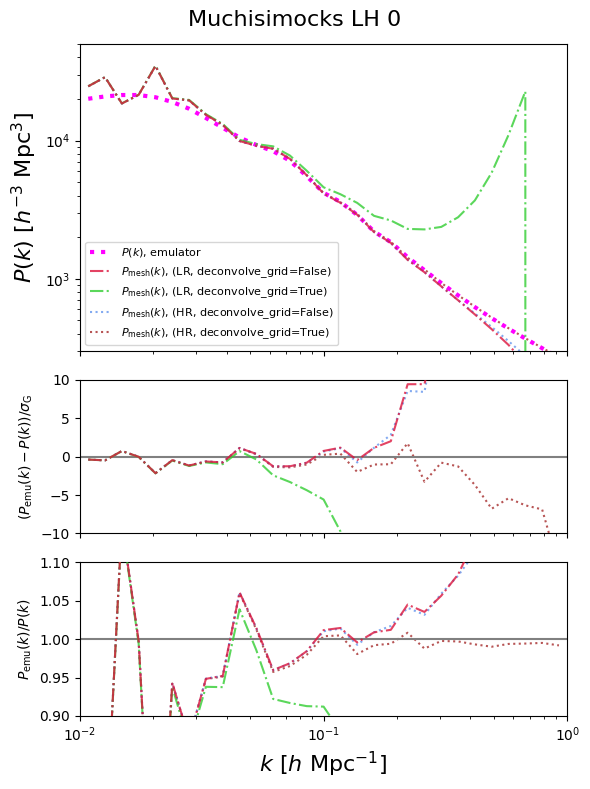

In [55]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
alpha = 0.8

# labels = [r'$P_\text{part}(k)$ (deconvolve_grid=False)', 
#           #r'$P_\text{mesh}(k)$ (deconvolve_grid=False)', 
#           r'$P_\text{part}(k)$ (deconvolve_grid=True)',
#           r'$P_\text{part}(k)$ (deconvolve_grid=True,'+'\n interlacing=True)',
#           r'$P_\text{part}(k)$ (deconvolve_grid=True,'+'\n correct_grid=False)',
#           r'$P_\text{mesh}(k)$ (deconvolve_grid=True)',
#           r'$P_\text{part}(k)$ (deconvolve_grid=True),'+'\n from Quijote snapshot',
#           ]
labels = [ #r'$P_\text{mesh}(k)$, from disp (HR, deconvolve_grid=False)',
          #r'$P_\text{mesh}(k)$, from disp (HR, deconvolve_grid=True)',
          r'$P_\text{mesh}(k)$, (LR, deconvolve_grid=False)',
          r'$P_\text{mesh}(k)$, (LR, deconvolve_grid=True)',
          r'$P_\text{mesh}(k)$, (HR, deconvolve_grid=False)',
          r'$P_\text{mesh}(k)$, (HR, deconvolve_grid=True)',
        #   r'$P_\text{mesh}(k)$ (LR, deconvolve_grid=False)',
        #   r'$P_\text{mesh}(k)$ (LR, deconvolve_grid=True)',
        #   #r'$P_\text{mesh}(k)$ (deconvolve_grid=True, correct_grid=True)',
        #   r'$P_\text{mesh}(k)$ (HR, deconvolve_grid=False)',
        #   r'$P_\text{mesh}(k)$ (HR, deconvolve_grid=True)'
          ]
colors = ['crimson', 'limegreen', 'cornflowerblue', 'brown', 'orange', 'darkblue', 'purple', 'grey']
lss = ['-.', '-.', ':', ':', '--', '--', '-', '-']
# pk_objs = [pk_obj_particles_nodeconv,
#            pk_obj_particles,
#            pk_obj_particles_interlacing,
#            pk_obj_particles_nocorrectgrid,
#            pk_obj_mesh, 
#            #pk_obj_particles_deconv_Mpcperh, 
#            #pk_obj_pos_mesh_deconv, 
#            pk_obj_snap,
#            ]
pk_objs = [#pk_obj_mesh_fromdisp_hr_deconvolveFalse,
           #pk_obj_mesh_fromdisp_hr,
           pk_obj_mesh_fromdisp_tracer_deconvolveFalse,
           pk_obj_mesh_fromdisp_tracer,
           pk_obj_mesh_fromdisp_tracer_hr_deconvolveFalse,
           pk_obj_mesh_fromdisp_tracer_hr,
        #    pk_obj_mesh_deconvolveFalse,
        #    pk_obj_mesh,
        #    #pk_obj_mesh_correctgridTrue,
        #    pk_obj_mesh_hr_deconvolveFalse,
        #    pk_obj_mesh_hr
           ]
zorders = list(range(len(pk_objs),0,-1))
ks = [pk_obj['k'] for pk_obj in pk_objs]
pks = [pk_obj['pk'] for pk_obj in pk_objs]
errs = [pk_obj['pk_gaussian_error'] for pk_obj in pk_objs]

# ks.append(k_quijote)
# pks.append(pk_quijote)
# errs.append(err_quijote)
# #errs.append(bacco.statistics.approx_pk_gaussian_error(k_quijote, pk_quijote, box_size))
# labels.append(r'$P(k)$, Quijote measured')
# colors.append('grey')
# lss.append('-')
# zorders.append(0)

plt.suptitle(f'Muchisimocks LH {idx_LH_str}', fontsize=16)

ax.loglog(kk, pk_emu, label=r'$P(k)$, emulator', ls=':', color='magenta', lw=3)

for i in range(len(pks)):
    ax.loglog(ks[i], pks[i], ls=lss[i], label=labels[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    if len(pk_emu)!=len(pks[i]):
        pk_interp = np.interp(kk, ks[i], pks[i])
        err_interp = np.interp(kk, ks[i], errs[i])
        ax1.plot(kk, (pk_emu-pk_interp)/err_interp, ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
        ax2.plot(kk, (pk_emu/pk_interp), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    else:
        ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
        ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])


ax1.axhline(0.0, color='grey')
ax2.axhline(1.0, color='grey')

ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P_\text{emu}(k)-P(k))/\sigma_\text{G}$')
ax2.set_ylabel(r'$P_\text{emu}(k)/P(k)$')
ax.set_xlim(1e-2, 1)
ax.set_ylim(3e2, 5e4)

ax1.set_ylim(-10, 10)
ax2.set_ylim(0.9, 1.1)

ax.legend(fontsize=8, loc='lower left')

mpl.pyplot.tight_layout()
mpl.pyplot.show()

## Try field-level deconvolution

In [57]:
import bacco.probabilistic_bias as pb

Checked that deconvolving each of the bias fields and then summing into a tracer field gives same result as deconvolving the tracer field directly! Including when bias vector is not all zeros (checked b=[1,0,0,0] case). So we could deconvolve the bias fields and save the deconvolved version.

In [89]:
# Have to do this in a loop, can't just pass bias_terms_eul_hr to the pb function - maybe could rewrite it, but rn no 
bias_terms_eul_hr_deconvolved = []
for i, bias_term in enumerate(bias_terms_eul_hr):
    bias_term_deconvolved = pb.convolve_linear_interpolation_kernel(bias_term, 
                                                                    npix=n_grid_orig, mode="deconvolve")
    bias_terms_eul_hr_deconvolved.append(bias_term_deconvolved)
bias_terms_eul_hr_deconvolved = np.array(bias_terms_eul_hr_deconvolved)
bias_terms_eul_hr_deconvolved.shape

(5, 512, 512, 512)

In [93]:
# Have to do this in a loop, can't just pass bias_terms_eul_hr to the pb function - maybe could rewrite it, but rn no 
bias_terms_eul_deconvolved = []
for i, bias_term in enumerate(bias_terms_eul):
    bias_term_deconvolved = pb.convolve_linear_interpolation_kernel(bias_term, 
                                                                    npix=n_grid_orig, mode="deconvolve")
    bias_terms_eul_deconvolved.append(bias_term_deconvolved)
bias_terms_eul_deconvolved = np.array(bias_terms_eul_deconvolved)
bias_terms_eul_deconvolved.shape

(5, 128, 128, 128)

In [90]:
tracer_field_hr_deconvolved = get_tracer_field(bias_terms_eul_hr_deconvolved, bias_vector, n_grid_norm=n_grid_orig)

In [94]:
tracer_field_deconvolved = get_tracer_field(bias_terms_eul_deconvolved, bias_vector, n_grid_norm=n_grid_orig)

In [99]:
bias_terms_eul_hr_deconvolved.shape

(5, 512, 512, 512)

In [113]:
ngrid_target = 128
bias_terms_eul_fromhrdeconvolved = downsample_field(bias_terms_eul_hr_deconvolved, box_size, ngrid_target)

In [114]:
tracer_field_fromhrdeconvolved = get_tracer_field(bias_terms_eul_fromhrdeconvolved, bias_vector, n_grid_norm=n_grid_orig)

-1.4575713133034672e-06 1.4508998989225246e-05
-1.4575713133034672e-06 1.4508998989225246e-05


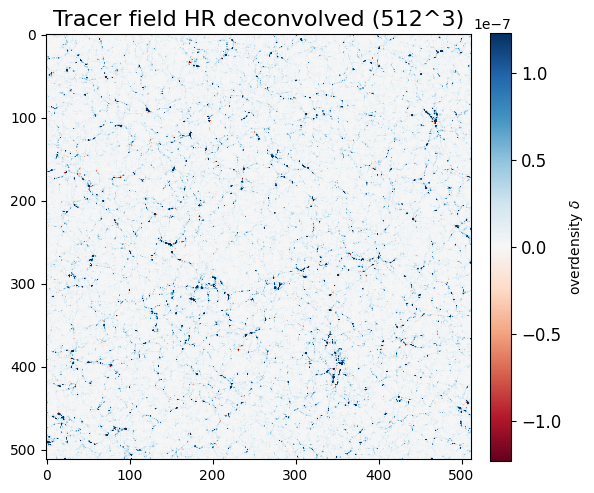

In [91]:
plotter.plot_overdensity_field(tracer_field_hr_deconvolved, title=r'Tracer field HR deconvolved (512^3)',
                               #vmax=0.1
                               )

-2.1424585630773332e-06 6.843647584940654e-06
-2.1424585630773332e-06 6.843647584940654e-06


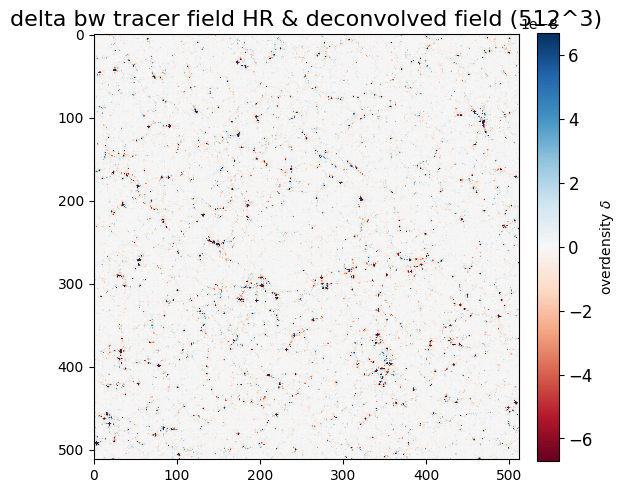

In [92]:
plotter.plot_overdensity_field(tracer_field_hr_deconvolved-tracer_field_hr, 
                               title=r'delta bw tracer field HR & deconvolved field (512^3)',
                               #vmax=0.1
                               )

In [95]:
pk_obj_mesh_fromdisp_tracer_hr_fielddeconvolved = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_hr_deconvolved,
                    grid2=tracer_field_hr_deconvolved,
                    **args_power_grid_hr_deconvolveFalse)

2024-07-09 19:15:46,225 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.114194 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.774032 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000148 secs
bacco.power : Deallocating arrays


2024-07-09 19:15:55,822 bacco.statistics :  ...done in 9.6 s


In [96]:
pk_obj_mesh_fromdisp_tracer_fielddeconvolved = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_deconvolved,
                    grid2=tracer_field_deconvolved,
                    **args_power_grid_deconvolveFalse)

2024-07-09 19:15:57,305 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-07-09 19:15:57,414 bacco.statistics :  ...done in 0.109 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.010691 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.044561 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000285 secs
bacco.power : Deallocating arrays


In [115]:
pk_obj_mesh_fromdisp_tracer_fromhrdeconvolved = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_fromhrdeconvolved,
                    grid2=tracer_field_fromhrdeconvolved,
                    **args_power_grid_deconvolveFalse)

2024-07-09 19:26:01,784 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-07-09 19:26:01,888 bacco.statistics :  ...done in 0.104 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.027780 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.044259 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000142 secs
bacco.power : Deallocating arrays


In [117]:
pk_obj_mesh_fromdisp_tracer_fromhrdeconvolved['pk']

array([24705.46494758, 28757.73279165, 18546.43028629, 21423.97727027,
       34695.96650419, 20178.20937091, 19546.9102048 , 15375.93416172,
       13001.91679315,  9935.600054  ,  9178.30131923,  8746.90924262,
        7394.04419036,  5627.87325459,  4164.95293083,  3576.9224826 ,
        2941.98626996,  2212.63593615,  1860.04700652,  1412.83815183,
        1163.52754177,   934.94939305,   758.94952395,   616.43186799,
         501.88362252,   405.99006205,   316.59611298,     0.        ,
           0.        ,     0.        ])

In [118]:
pk_obj_mesh_fromdisp_tracer_fielddeconvolved['pk']

array([24705.46618721, 28757.77154132, 18546.42941908, 21423.97698639,
       34695.96314447, 20178.20662781, 19546.908774  , 15375.93358568,
       13001.91480163,  9935.59845288,  9178.29983982,  8746.90787314,
        7394.04303923,  5627.87235318,  4164.95219632,  3576.92178936,
        2941.98570711,  2212.63551902,  1860.04664784,  1412.83789325,
        1163.52732116,   934.94921264,   758.94937519,   616.43174794,
         501.88352256,   405.9899843 ,   316.59605568,     0.        ,
           0.        ,     0.        ])

/tmp/ipykernel_229281/459357789.py:72: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
/tmp/ipykernel_229281/459357789.py:73: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])


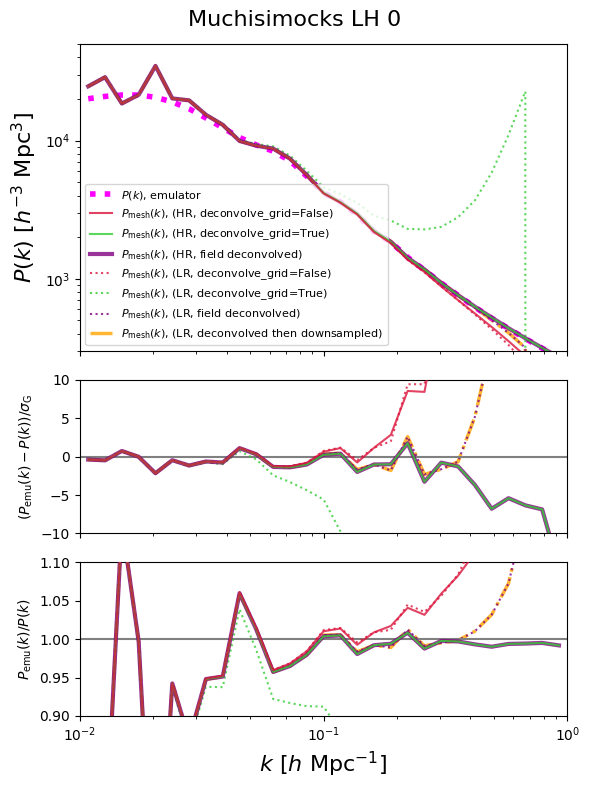

In [138]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
alpha = 0.8

# labels = [r'$P_\text{part}(k)$ (deconvolve_grid=False)', 
#           #r'$P_\text{mesh}(k)$ (deconvolve_grid=False)', 
#           r'$P_\text{part}(k)$ (deconvolve_grid=True)',
#           r'$P_\text{part}(k)$ (deconvolve_grid=True,'+'\n interlacing=True)',
#           r'$P_\text{part}(k)$ (deconvolve_grid=True,'+'\n correct_grid=False)',
#           r'$P_\text{mesh}(k)$ (deconvolve_grid=True)',
#           r'$P_\text{part}(k)$ (deconvolve_grid=True),'+'\n from Quijote snapshot',
#           ]
labels = [
          r'$P_\text{mesh}(k)$, (HR, deconvolve_grid=False)',
          r'$P_\text{mesh}(k)$, (HR, deconvolve_grid=True)',
          r'$P_\text{mesh}(k)$, (HR, field deconvolved)',          
          r'$P_\text{mesh}(k)$, (LR, deconvolve_grid=False)',
          r'$P_\text{mesh}(k)$, (LR, deconvolve_grid=True)',
          r'$P_\text{mesh}(k)$, (LR, field deconvolved)',
          r'$P_\text{mesh}(k)$, (LR, deconvolved then downsampled)',
          ]
colors = ['crimson', 'limegreen', 'purple', 
          'crimson', 'limegreen', 'purple', 
          'orange']
lss = ['-', '-', '-',
       ':', ':', ':', '-.']
lws = [1.5, 1.5, 3,
       1.5, 1.5, 1.5, 2.5]
# lws = [2, 2, 1,
#        2, 2, 2, 1]
pk_objs = [pk_obj_mesh_fromdisp_tracer_hr_deconvolveFalse,
           pk_obj_mesh_fromdisp_tracer_hr,
           pk_obj_mesh_fromdisp_tracer_hr_fielddeconvolved,
           pk_obj_mesh_fromdisp_tracer_deconvolveFalse,
           pk_obj_mesh_fromdisp_tracer,
           pk_obj_mesh_fromdisp_tracer_fielddeconvolved,
           pk_obj_mesh_fromdisp_tracer_fromhrdeconvolved,
        #    pk_obj_mesh_deconvolveFalse,
        #    pk_obj_mesh,
        #    #pk_obj_mesh_correctgridTrue,
        #    pk_obj_mesh_hr_deconvolveFalse,
        #    pk_obj_mesh_hr
           ]
zorders = list(range(len(pk_objs),0,-1))
ks = [pk_obj['k'] for pk_obj in pk_objs]
pks = [pk_obj['pk'] for pk_obj in pk_objs]
errs = [pk_obj['pk_gaussian_error'] for pk_obj in pk_objs]

# ks.append(k_quijote)
# pks.append(pk_quijote)
# errs.append(err_quijote)
# #errs.append(bacco.statistics.approx_pk_gaussian_error(k_quijote, pk_quijote, box_size))
# labels.append(r'$P(k)$, Quijote measured')
# colors.append('grey')
# lss.append('-')
# zorders.append(0)

plt.suptitle(f'Muchisimocks LH {idx_LH_str}', fontsize=16)

ax.loglog(kk, pk_emu, label=r'$P(k)$, emulator', ls=':', color='magenta', lw=4)

for i in range(len(pks)):
    ax.loglog(ks[i], pks[i], ls=lss[i], label=labels[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
    if len(pk_emu)!=len(pks[i]):
        pk_interp = np.interp(kk, ks[i], pks[i])
        err_interp = np.interp(kk, ks[i], errs[i])
        ax1.plot(kk, (pk_emu-pk_interp)/err_interp, ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
        ax2.plot(kk, (pk_emu/pk_interp), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
    else:
        ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
        ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])


ax1.axhline(0.0, color='grey')
ax2.axhline(1.0, color='grey')

ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P_\text{emu}(k)-P(k))/\sigma_\text{G}$')
ax2.set_ylabel(r'$P_\text{emu}(k)/P(k)$')
ax.set_xlim(1e-2, 1)
ax.set_ylim(3e2, 5e4)

ax1.set_ylim(-10, 10)
ax2.set_ylim(0.9, 1.1)

ax.legend(fontsize=8, loc='lower left')

mpl.pyplot.tight_layout()
mpl.pyplot.show()

## Check deconvolved lib

In [139]:
idx_LH = 0
idx_LH_str = str(idx_LH)

# order of saved cosmo param files
param_names_all = ['omega_cold', 'sigma_8', 'h', 'omega_baryon', 'n_s', 'seed']
    
n_grid = 128
n_grid_orig = 512
box_size = 1000.0

In [140]:
# Quijote LH test data

# still had LH0 in map2map emu dir, preeeetty sure its LH0 cosmo params

tag_lib = '_deconvolved'
dir_lib = f'/cosmos_storage/cosmosims/muchisimocks_lib{tag_lib}'
dir_params = f'/dipc/kstoreyf/muchisimocks/data/cosmolib'

In [141]:
fn_params = f'{dir_params}/LH{idx_LH}/cosmo_{idx_LH}.txt'
param_vals = np.loadtxt(fn_params)
param_dict = dict(zip(param_names_all, param_vals))
#del param_dict['seed']
print(param_dict)
cosmo = utils.get_cosmo(param_dict)


2024-07-10 14:58:48,867 bacco.cosmo :    initialization took 0.000 secs


{'omega_cold': 0.2775274936564327, 'sigma_8': 0.7049140324569382, 'h': 0.7241123952301097, 'omega_baryon': 0.049, 'n_s': 0.9624, 'seed': 0.0}


In [144]:

tag_fields = '_deconvolved_lr'
tag_fields_extra = ''

fn_fields = f'{dir_lib}/LH{idx_LH}/Eulerian_fields{tag_fields}_{idx_LH}{tag_fields_extra}.npy'
bias_vector = [0.,0.,0.,0.]

bias_terms_eul_lib = np.load(fn_fields)
tracer_field_lib = get_tracer_field(bias_terms_eul_lib, bias_vector, n_grid_norm=n_grid_orig)

In [145]:
pk_obj_lib = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_lib,
                    grid2=tracer_field_lib,
                    **args_power_grid_deconvolveFalse)

2024-07-10 15:01:35,338 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-07-10 15:01:35,433 bacco.statistics :  ...done in 0.0946 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014973 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.046270 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000404 secs
bacco.power : Deallocating arrays


/tmp/ipykernel_229281/2827822173.py:60: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
/tmp/ipykernel_229281/2827822173.py:61: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])


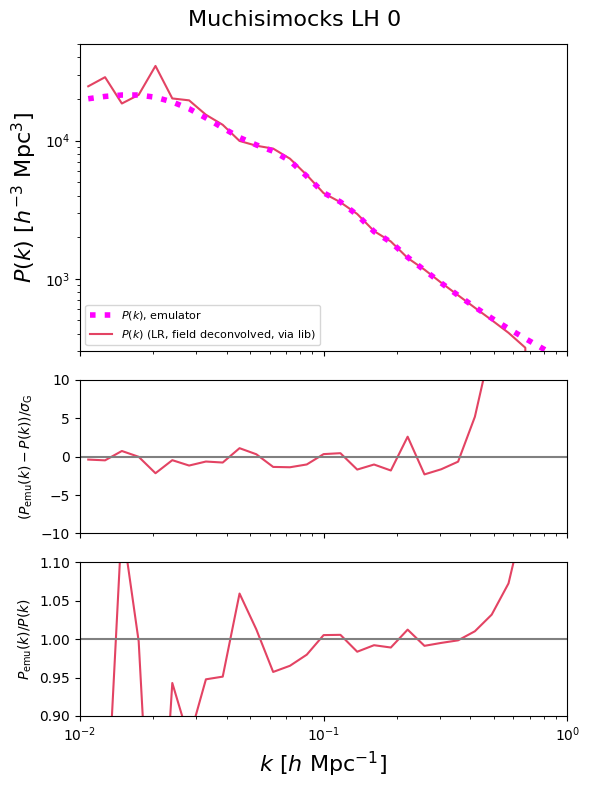

In [146]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
alpha = 0.8

# labels = [r'$P_\text{part}(k)$ (deconvolve_grid=False)', 
#           #r'$P_\text{mesh}(k)$ (deconvolve_grid=False)', 
#           r'$P_\text{part}(k)$ (deconvolve_grid=True)',
#           r'$P_\text{part}(k)$ (deconvolve_grid=True,'+'\n interlacing=True)',
#           r'$P_\text{part}(k)$ (deconvolve_grid=True,'+'\n correct_grid=False)',
#           r'$P_\text{mesh}(k)$ (deconvolve_grid=True)',
#           r'$P_\text{part}(k)$ (deconvolve_grid=True),'+'\n from Quijote snapshot',
#           ]
labels = [
          r'$P(k)$ (LR, field deconvolved, via lib)',
          ]
colors = ['crimson', 'limegreen', 'purple', 
          'crimson', 'limegreen', 'purple', 
          'orange']
lss = ['-', '-', '-',
       ':', ':', ':', '-.']
lws = [1.5, 1.5, 3,
       1.5, 1.5, 1.5, 2.5]
# lws = [2, 2, 1,
#        2, 2, 2, 1]
pk_objs = [pk_obj_lib,
        #    pk_obj_mesh_deconvolveFalse,
        #    pk_obj_mesh,
        #    #pk_obj_mesh_correctgridTrue,
        #    pk_obj_mesh_hr_deconvolveFalse,
        #    pk_obj_mesh_hr
           ]
zorders = list(range(len(pk_objs),0,-1))
ks = [pk_obj['k'] for pk_obj in pk_objs]
pks = [pk_obj['pk'] for pk_obj in pk_objs]
errs = [pk_obj['pk_gaussian_error'] for pk_obj in pk_objs]

# ks.append(k_quijote)
# pks.append(pk_quijote)
# errs.append(err_quijote)
# #errs.append(bacco.statistics.approx_pk_gaussian_error(k_quijote, pk_quijote, box_size))
# labels.append(r'$P(k)$, Quijote measured')
# colors.append('grey')
# lss.append('-')
# zorders.append(0)

plt.suptitle(f'Muchisimocks LH {idx_LH_str}', fontsize=16)

ax.loglog(kk, pk_emu, label=r'$P(k)$, emulator', ls=':', color='magenta', lw=4)

for i in range(len(pks)):
    ax.loglog(ks[i], pks[i], ls=lss[i], label=labels[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
    if len(pk_emu)!=len(pks[i]):
        pk_interp = np.interp(kk, ks[i], pks[i])
        err_interp = np.interp(kk, ks[i], errs[i])
        ax1.plot(kk, (pk_emu-pk_interp)/err_interp, ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
        ax2.plot(kk, (pk_emu/pk_interp), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
    else:
        ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
        ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])


ax1.axhline(0.0, color='grey')
ax2.axhline(1.0, color='grey')

ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P_\text{emu}(k)-P(k))/\sigma_\text{G}$')
ax2.set_ylabel(r'$P_\text{emu}(k)/P(k)$')
ax.set_xlim(1e-2, 1)
ax.set_ylim(3e2, 5e4)

ax1.set_ylim(-10, 10)
ax2.set_ylim(0.9, 1.1)

ax.legend(fontsize=8, loc='lower left')

mpl.pyplot.tight_layout()
mpl.pyplot.show()